In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib inline

import datetime

import statsmodels.tsa.api as smt

In [2]:
def load_data():  
    return pd.read_excel('Volume.xlsx')  

sales_data = load_data()

In [3]:
sales_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31 entries, 0 to 30
Data columns (total 3 columns):
volume     31 non-null int64
sales      31 non-null int64
date       31 non-null datetime64[ns]
dtypes: datetime64[ns](1), int64(2)
memory usage: 824.0 bytes


In [4]:
sales_data.head()

,volume,sales,date
0,56,2480124,2009-12-04
1,57,2578730,2010-03-04
2,58,2557356,2010-06-04
3,59,2593580,2010-08-04
4,60,2492183,2010-11-04


In [5]:
def monthly_sales(data):
    monthly_data = data.copy()
    monthly_data.date = monthly_data.date.apply(lambda x: str(x)[:-3])
    monthly_data = monthly_data.groupby('date')['sales'].sum().reset_index()
    monthly_data.date = pd.to_datetime(monthly_data.date)
    return monthly_data

In [6]:
monthly_df = monthly_sales(sales_data)
monthly_df.head()

,date,sales
0,2009-12-04,2480124
1,2010-03-04,2578730
2,2010-06-04,2557356
3,2010-08-04,2593580
4,2010-11-04,2492183


In [7]:
# Duration of dataset
def sales_duration(data):
    data.date = pd.to_datetime(data.date)
    number_of_days = data.date.max() - data.date.min()
    number_of_years = number_of_days.days / 365
    print(number_of_days.days, 'days')
    print(number_of_years, 'years')
    
sales_duration(sales_data)

2800 days
7.671232876712328 years


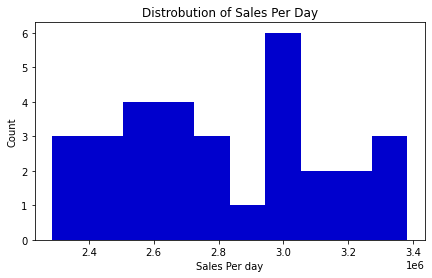

In [8]:
def sales_per_day():
    fig, ax = plt.subplots(figsize=(7,4))
    plt.hist(sales_data.sales, color='mediumblue')
    
    ax.set(xlabel = "Sales Per day",
           ylabel = "Count",
           title = "Distrobution of Sales Per Day")
    
sales_per_day()

In [9]:

def sales_per_store():
    by_store = sales_data.groupby('volume')['sales'].sum().reset_index()
    
    fig, ax = plt.subplots(figsize=(7,4))
    sns.barplot(by_store.store, by_store.sales, color='mediumblue')
    
    ax.set(xlabel = "volume",
           ylabel = "Number of Sales",
           title = "Total Sales Per volume")
    
    sns.despine()
    
sales_per_store()

KeyError: 'volume'

In [10]:
# Average monthly sales

# Overall
avg_monthly_sales = monthly_df.sales.mean()
print(f"Overall average monthly sales: ${avg_monthly_sales}")

# Last 12 months (this will be the forecasted sales)
avg_monthly_sales_12month = monthly_df.sales[-12:].mean()
print(f"Last 12 months average monthly sales: ${avg_monthly_sales_12month}")

Overall average monthly sales: $2822321.7419354836
Last 12 months average monthly sales: $2758697.5


In [11]:
def time_plot(data, x_col, y_col, title):
    fig, ax = plt.subplots(figsize=(15,5))
    sns.lineplot(x_col, y_col, data=data, ax=ax, color='mediumblue', label='Total Sales')
    
    second = data.groupby(data.date.dt.year)[y_col].mean().reset_index()
    second.date = pd.to_datetime(second.date, format='%Y')
    sns.lineplot((second.date + datetime.timedelta(6*365/12)), y_col, data=second, ax=ax, color='red', label='Mean Sales')   
    
    ax.set(xlabel = "Date",
           ylabel = "Sales",
           title = title)
    
    sns.despine()

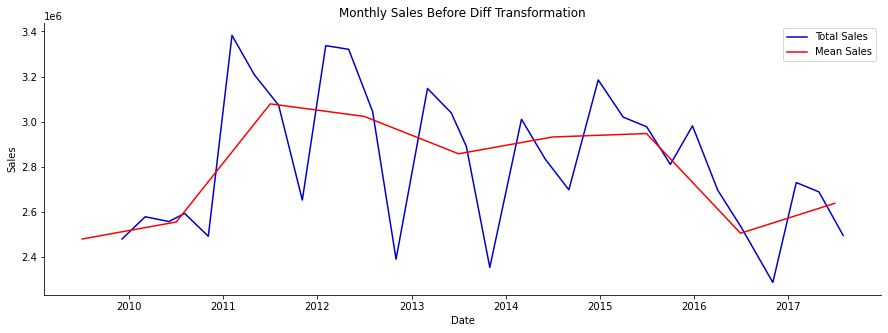

In [12]:

time_plot(monthly_df, 'date', 'sales', 'Monthly Sales Before Diff Transformation')

In [15]:
def get_diff(data):
    data['sales_diff'] = data.sales.diff()
    data = data.dropna()
    
    data.to_csv('stationary_df.csv')
    return data

In [16]:
stationary_df = get_diff(monthly_df)

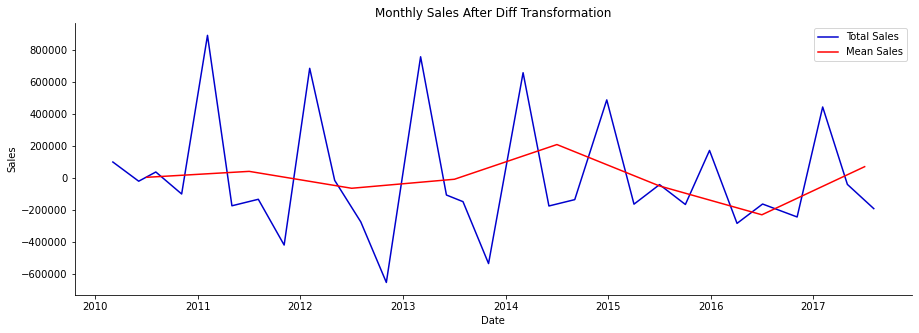

In [17]:
time_plot(stationary_df, 'date', 'sales_diff', 'Monthly Sales After Diff Transformation')

C:\Users\rohan\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1406: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


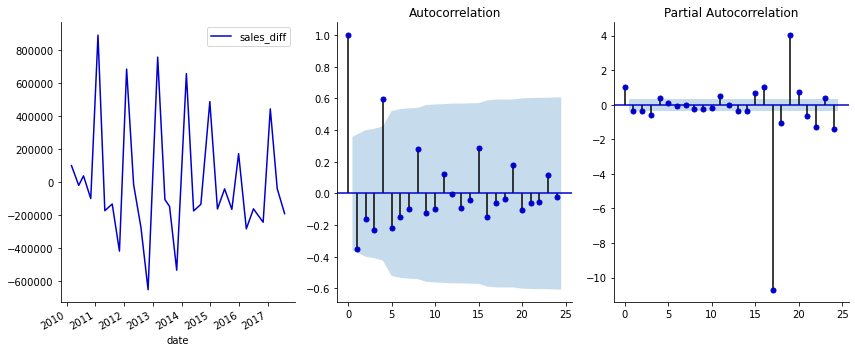

In [18]:
def plots(data, lags=None):
    
    # Convert dataframe to datetime index
    dt_data = data.set_index('date').drop('sales', axis=1)
    dt_data.dropna(axis=0)
    
    layout = (1, 3)
    raw  = plt.subplot2grid(layout, (0, 0))
    acf  = plt.subplot2grid(layout, (0, 1))
    pacf = plt.subplot2grid(layout, (0, 2))
    
    dt_data.plot(ax=raw, figsize=(12, 5), color='mediumblue')
    smt.graphics.plot_acf(dt_data, lags=lags, ax=acf, color='mediumblue')
    smt.graphics.plot_pacf(dt_data, lags=lags, ax=pacf, color='mediumblue')
    sns.despine()
    plt.tight_layout()

plots(stationary_df, lags=24);

In [19]:
#create dataframe for transformation from time series to supervised
def generate_supervised(data):
    supervised_df = data.copy()
    
    #create column for each lag
    for i in range(1,13):
        col_name = 'lag_' + str(i)
        supervised_df[col_name] = supervised_df['sales_diff'].shift(i)
    
    #drop null values
    supervised_df = supervised_df.dropna().reset_index(drop=True)
    
    supervised_df.to_csv('model_df.csv', index=False)
    
    return supervised_df

In [20]:
model_df = generate_supervised(stationary_df)

In [21]:
model_df

,date,sales,sales_diff,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12
0,2013-03-04,3147224,756599.0,-654276.0,-275843.0,-16248.0,684292.0,-420475.0,-134393.0,-175020.0,890405.0,-101397.0,36224.0,-21374.0,98606.0
1,2013-06-04,3039487,-107737.0,756599.0,-654276.0,-275843.0,-16248.0,684292.0,-420475.0,-134393.0,-175020.0,890405.0,-101397.0,36224.0,-21374.0
2,2013-08-02,2890263,-149224.0,-107737.0,756599.0,-654276.0,-275843.0,-16248.0,684292.0,-420475.0,-134393.0,-175020.0,890405.0,-101397.0,36224.0
3,2013-11-01,2354005,-536258.0,-149224.0,-107737.0,756599.0,-654276.0,-275843.0,-16248.0,684292.0,-420475.0,-134393.0,-175020.0,890405.0,-101397.0
4,2014-03-04,3010801,656796.0,-536258.0,-149224.0,-107737.0,756599.0,-654276.0,-275843.0,-16248.0,684292.0,-420475.0,-134393.0,-175020.0,890405.0
5,2014-06-04,2834558,-176243.0,656796.0,-536258.0,-149224.0,-107737.0,756599.0,-654276.0,-275843.0,-16248.0,684292.0,-420475.0,-134393.0,-175020.0
6,2014-09-04,2698071,-136487.0,-176243.0,656796.0,-536258.0,-149224.0,-107737.0,756599.0,-654276.0,-275843.0,-16248.0,684292.0,-420475.0,-134393.0
7,2014-12-27,3185018,486947.0,-136487.0,-176243.0,656796.0,-536258.0,-149224.0,-107737.0,756599.0,-654276.0,-275843.0,-16248.0,684292.0,-420475.0
8,2015-04-03,3020137,-164881.0,486947.0,-136487.0,-176243.0,656796.0,-536258.0,-149224.0,-107737.0,756599.0,-654276.0,-275843.0,-16248.0,684292.0
9,2015-07-03,2977466,-42671.0,-164881.0,486947.0,-136487.0,-176243.0,656796.0,-536258.0,-149224.0,-107737.0,756599.0,-654276.0,-275843.0,-16248.0
